In [1]:
from packages import kuramoto as kr
from packages import kuramoto_nex as nkr
from packages import plotting

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm, trange
from sklearn.metrics import mean_squared_error



np.random.seed(42)

In [2]:
def getReservoir(matrix, time_interval=10):
    sampled_matrix = matrix[:, ::time_interval]
    diff_matrix = np.diff(sampled_matrix, n=1, axis=1)
    reservoir_t = diff_matrix.flatten(order='K')
    #print(sampled_matrix.shape)
    #print(diff_matrix.shape)
    #print(reservoir_t.shape)

    return reservoir_t
def ridge_regression(trainRes, trainData, reg):
    ResSize = trainRes.shape[1]
    Wout = np.linalg.solve(np.dot(trainRes.T, trainRes) + reg*np.eye(ResSize), np.dot(trainRes.T, trainData))
    return Wout

def getLastPhase(matrix):
    return matrix[:,-1]

def getNextPhase(matrix, model):
    act_mat = model.run(adj_mat=graph, angles_vec=matrix)
    phase = getLastPhase(matrix=act_mat)
    
    return phase
def getPerturbedPhase(t, input_data, index, phase):
    for (i,j) in enumerate(index):
        phase[j] += input_data[t, i]
    
    return phase

In [3]:
def find_critical_coupling(graph, init_phase, natfreqs):
    t = np.linspace(0, 4, 51)
    order_ex = []
    variance_ex = []

    order_nex = []
    variance_nex = []

    for k in tqdm(t):
        model_ex = kr.Kuramoto(coupling=k, dt=0.01, T=10, n_nodes=len(graph), natfreqs=natfreqs)
        model_nex = nkr.Kuramoto(coupling=k, dt=0.01, T=10, n_nodes=len(graph), natfreqs=natfreqs)
        # Run simulation - output is time series for all nodes (node vs time)
        act_mat_ex = model_ex.run(adj_mat=graph, angles_vec = init_phase)
        act_mat_nex = model_nex.run(adj_mat=graph, angles_vec = init_phase)

        order_ex.append(model_ex.phase_coherence(act_mat_ex[:,-1]))
        variance_ex.append(model_ex.mean_frequency(act_mat_ex, graph))

        order_nex.append(model_nex.phase_coherence(act_mat_nex[:,-1]))
        variance_nex.append(model_nex.mean_frequency(act_mat_nex, graph))

    return t, order_ex, variance_ex, order_nex, variance_nex

## Define parameters

In [49]:
NODE = 100
graph_nx = nx.erdos_renyi_graph(n=NODE, p=1, seed=42) # p=1 -> all-to-all connectivity
graph = nx.to_numpy_array(graph_nx)

init_phase = 2 * np.pi * np.random.random(size=NODE)
natfreqs = np.random.normal(loc = 0, scale = 1, size = NODE)

In [50]:
t, order_ex, variance_ex, order_nex, variance_nex = find_critical_coupling(graph, init_phase, natfreqs)

100%|██████████| 51/51 [00:16<00:00,  3.17it/s]


In [51]:
# Create subplot figure with shared axes
fig = make_subplots(rows=1, cols=2, subplot_titles=["(a) Kuramoto Order Parameters", "(b) Variance Order Parameters"], horizontal_spacing=0.1, shared_xaxes=True)

# Add traces to subplot 1
fig.add_trace(
    go.Scatter(x=t, y=order_ex, mode='markers+lines', marker=dict(color='red', size=4), line=dict(width=0.8), name='Order Ex'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=t, y=order_nex, mode='markers+lines', marker=dict(color='black', size=4), line=dict(width=0.8), name='Order Nex'),
    row=1, col=1
)
fig.update_yaxes(title_text='$r$', range=[0,1], row=1, col=1)

# Add traces to subplot 2
fig.add_trace(
    go.Scatter(x=t, y=variance_ex, mode='markers+lines', marker=dict(color='red', size=4), line=dict(width=0.8), name='Variance Ex'),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(x=t, y=variance_nex, mode='markers+lines', marker=dict(color='black', size=4), line=dict(width=0.8), name='Variance Nex'),
    row=1, col=2
)
fig.update_yaxes(title_text=r'$r_{var}$', range=[0,1], row=1, col=2)

# Update layout with synchronized hovermode
fig.update_layout(height=500, width=900, showlegend=False, title_text=f"Kuramoto and Variance Order Parameters (N={NODE})", title_x=0.5, hovermode='x unified')

fig.show()

## Load data

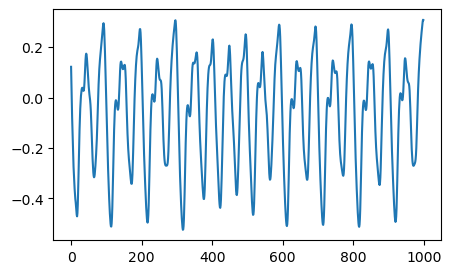

In [52]:
data = np.loadtxt('MackeyGlass.txt')

plt.figure(figsize=(5,3))
plt.plot(data[:1000])

In [53]:
def evaluate(graph, init_phase, natfreqs, critical_coupling=np.e, dt=0.01, input_interval=10):
    #critical_coupling = 2.7
    hist = []
    
    critical_model = kr.Kuramoto(coupling=critical_coupling, dt=dt, T=10, n_nodes=len(graph), natfreqs=natfreqs)
    act_mat = critical_model.run(adj_mat=graph, angles_vec = init_phase)

    ResSize = 1500
    push = 500
    trainLen = ResSize-push
    testLen = 1000
    #x = np.linspace(0, 1000,10000)
    #data = np.sin(x)
    input_data = data.reshape(-1,1)
    trainData = input_data[push+1:push+trainLen+1,:]

    sample_interval=10*input_interval

    # Now we are ready to perturb data
    reservoir = []

    act_mat_hist = []

    synced_phases = act_mat[:,-1]

    model = kr.Kuramoto(coupling=critical_coupling, dt=dt, T=dt, n_nodes=NODE, natfreqs=natfreqs)
    synced_phases = getNextPhase(matrix=synced_phases, model=model)

    model = kr.Kuramoto(coupling=critical_coupling, dt=dt, T=input_interval+dt, n_nodes=NODE, natfreqs=natfreqs)

    for t in trange(0, ResSize):
        perturbed_phases = getPerturbedPhase(t, input_data=input_data, index=[0], phase=synced_phases)
        act_mat = model.run(adj_mat=graph, angles_vec=perturbed_phases)
        
        reservoir.append(getReservoir(matrix=act_mat, time_interval=sample_interval))
        synced_phases = getLastPhase(matrix=act_mat)

        act_mat_hist.append(act_mat)

    reservoir_T = np.vstack(reservoir)
    trainRes = reservoir_T[push:push+trainLen,:]

    reg = 1e-8  # regularization coefficient
    Wout = ridge_regression(trainRes, trainData, reg)

    
    testData = input_data[push+trainLen+1:push+trainLen+1+testLen,:]

    target = trainData[-1,:].reshape(-1,1)

    pred = []

    model = kr.Kuramoto(coupling=critical_coupling, dt=dt, T=dt, n_nodes=NODE, natfreqs=natfreqs)
    synced_phases = getNextPhase(matrix=synced_phases, model=model)

    model = kr.Kuramoto(coupling=critical_coupling, dt=dt, T=input_interval+dt, n_nodes=NODE, natfreqs=natfreqs)

    for t in trange(0, testLen):
        for (i,j) in enumerate([0]):
            synced_phases[j] += target[i]
            
        act_mat = model.run(adj_mat=graph, angles_vec = synced_phases)
        act_mat_sampled = act_mat[:, ::sample_interval]
        act_mat_diff = np.diff(act_mat_sampled, n=1, axis=1)
        reservoir_t = act_mat_diff.flatten(order='K')
        pred.append(np.matmul(reservoir_t, Wout))

        synced_phases = getLastPhase(matrix=act_mat)
        target = pred[-1]

    pred = np.vstack(pred)
    act_mat_hist = np.hstack(act_mat_hist)

    RMSE = mean_squared_error(testData, pred)**0.5
    print(RMSE)
    
    #plt.plot(pred)
    
    return pred, testData, act_mat_hist, RMSE


In [54]:
pred, testData, act_mat_hist, RMSE = evaluate(graph=graph,
                                              init_phase=init_phase,
                                              natfreqs=natfreqs,
                                              critical_coupling=2.7,
                                              dt=0.01,
                                              input_interval=10
                                              )

100%|██████████| 1000/1000 [00:27<00:00, 36.94it/s]


0.24149144593479063


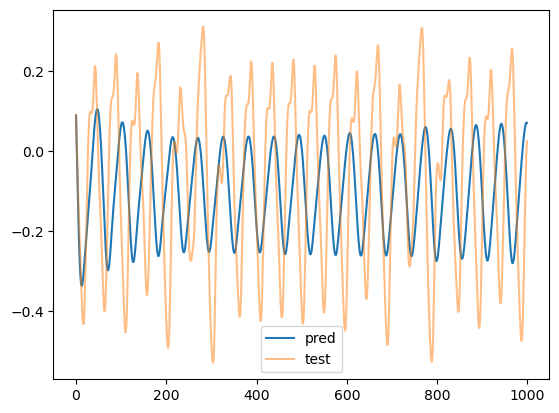

In [55]:
plt.plot(pred, label='pred')
plt.plot(testData, label='test', alpha=0.5)
plt.legend()

<Axes: xlabel='Time', ylabel='$\\sin(\\theta)$'>

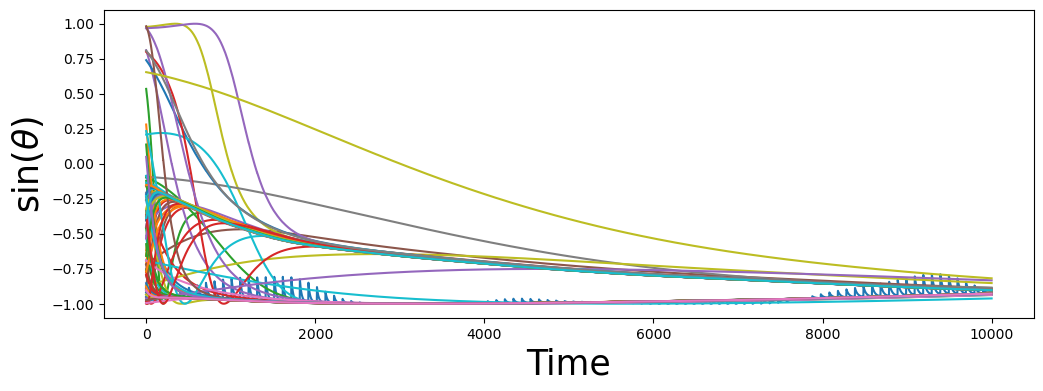

In [38]:
plotting.plot_activity(act_mat_hist[:,:10000])